<a href="https://colab.research.google.com/github/Pburman953/ModBot/blob/main/ModBot_Model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import string
import zipfile

#import emoji
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#import spacy
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
#from torchtext.data.utils import get_tokenizer
#from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm
from torch.utils.data import Dataset

import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pd.set_option('display.max_colwidth', None)
training_data = pd.read_csv('/content/drive/MyDrive/University/Comp 3000/Dataset/train.csv/train.csv')
print(training_data.shape)

print(training_data.head(500))

(159571, 8)
                   id  \
0    0000997932d777bf   
1    000103f0d9cfb60f   
2    000113f07ec002fd   
3    0001b41b1c6bb37e   
4    0001d958c54c6e35   
..                ...   
495  014b44616d8cb457   
496  014bb932bd289352   
497  014c96f873db11ff   
498  014d00c8f2a76df4   
499  014f50b1f448cb2d   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [ ]:
pd.set_option('display.max_colwidth', None)
testing_data = pd.read_csv('/content/drive/MyDrive/University/Comp 3000/Dataset/test.csv/test.csv')
print(testing_data.shape)

print(testing_data.head(500).to_string(index=False))

In [ ]:
pd.set_option('display.max_colwidth', None)
testing_data_labels = pd.read_csv('/content/drive/MyDrive/University/Comp 3000/Dataset/test_labels.csv/test_labels.csv')
print(testing_data_labels.shape)

print(testing_data_labels.to_string(index=False))


Streaming output truncated to the last 5000 lines.
f79dd1fb92ab9ae6     -1            -1       -1      -1      -1             -1
f79dd55171e29ff4      0             0        0       0       0              0
f79de2c201de354b      0             0        0       0       0              0
f79e71dd2f8c8c0d     -1            -1       -1      -1      -1             -1
f79ef4f6aac10d09      0             0        0       0       0              0
f7a05be4a1a1e6e1     -1            -1       -1      -1      -1             -1
f7a0774c320e1917      0             0        0       0       0              0
f7a0e4597871ead4      0             0        0       0       0              0
f7a11cf11e311a6e     -1            -1       -1      -1      -1             -1
f7a1418bfffd611c     -1            -1       -1      -1      -1             -1
f7a14add4307d9eb     -1            -1       -1      -1      -1             -1
f7a158cff138cc04      0             0        0       0       0              0
f7a1ddd8aed97

eda

In [ ]:
import seaborn as sns
plt.style.use('ggplot')


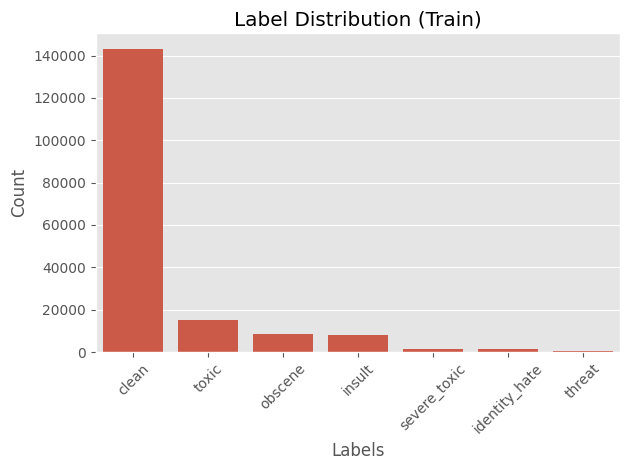

In [ ]:
# List of label columns
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Count how many comments are clean (i.e., all 0s across labels)
training_data["clean"] = (training_data[label_cols].sum(axis=1) == 0).astype(int)
clean_count = training_data["clean"].sum()

# Melt the dataframe so each label becomes a row
melted = training_data[label_cols].melt(var_name='label', value_name='value')
melted = melted[melted['value'] == 1]

# Add the "clean" rows manually (fix: same length for both columns)
clean_df = pd.DataFrame({
    "label": ["clean"] * clean_count,
    "value": [1] * clean_count
})

# Combine toxic + clean labels
melted_with_clean = pd.concat([melted, clean_df], ignore_index=True)

# Plot
sns.countplot(x='label', data=melted_with_clean, order=melted_with_clean['label'].value_counts().index)
plt.title("Label Distribution (Train)")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

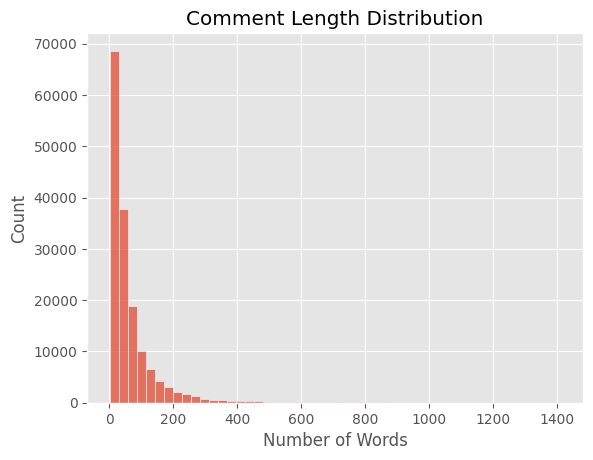

In [ ]:
training_data["comment_text_len"] = training_data["comment_text"].apply(lambda x: len(x.split()))
sns.histplot(training_data["comment_text_len"], bins=50)
plt.title("Comment Length Distribution")
plt.xlabel("Number of Words")
plt.show()


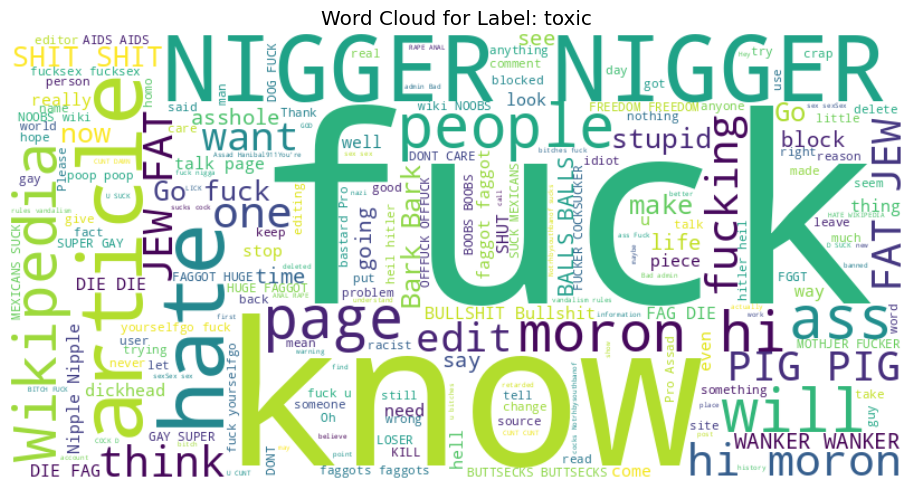

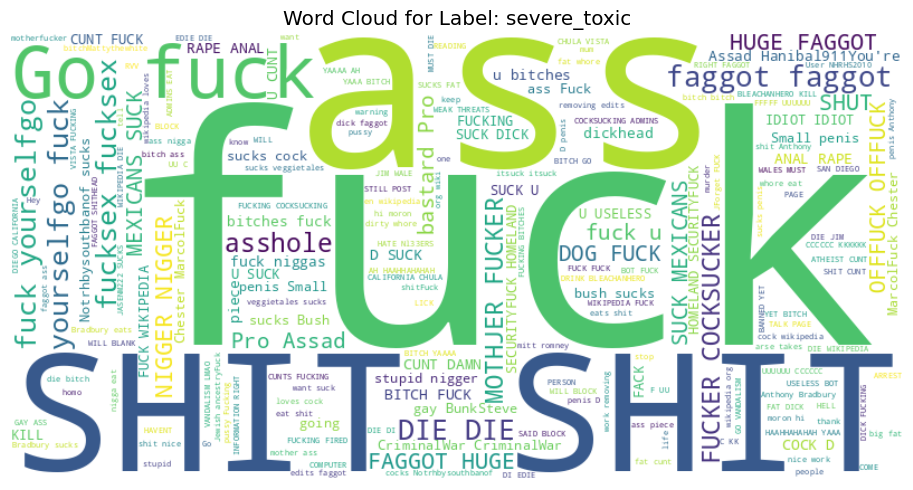

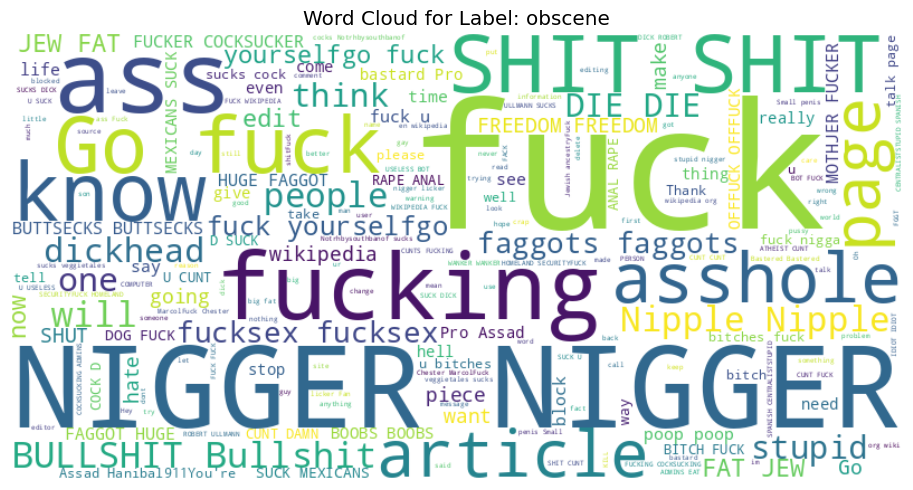

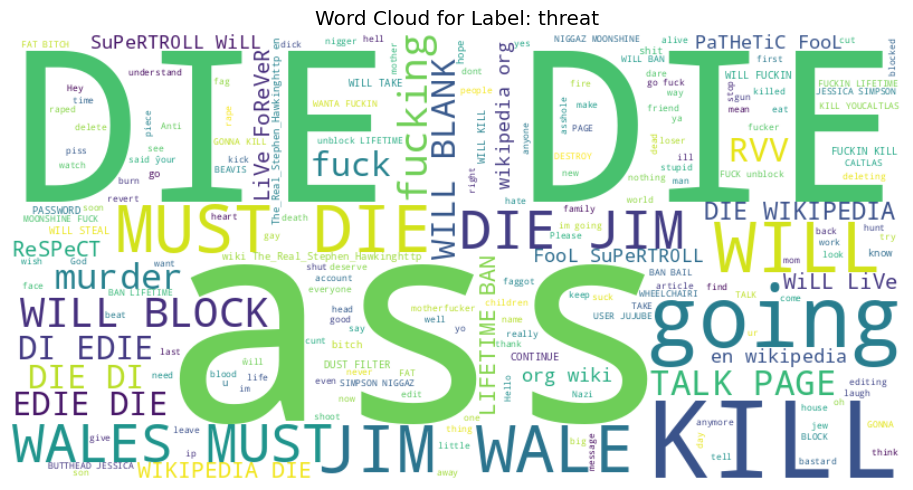

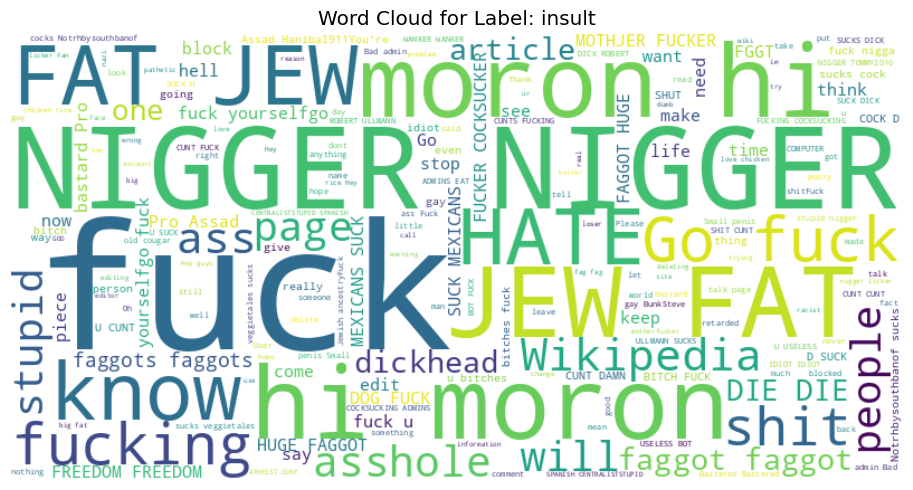

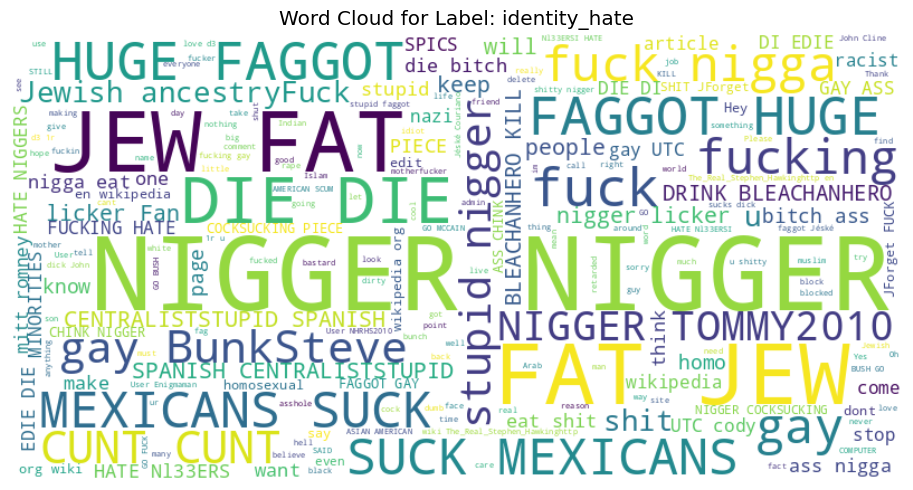

In [ ]:
from wordcloud import WordCloud

# Assuming 'comment_text' is your text column
text_column = "comment_text"  # Adjust this if your column name is different
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

for label in label_cols:
    # Filter comments where the label is 1
    text = " ".join(training_data[training_data[label] == 1][text_column].astype(str))

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Label: {label}")
    plt.tight_layout()
    plt.show()

Top words for label: toxic


<ipython-input-12-2a5cf608120c>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words, x="count", y="word", palette="viridis")


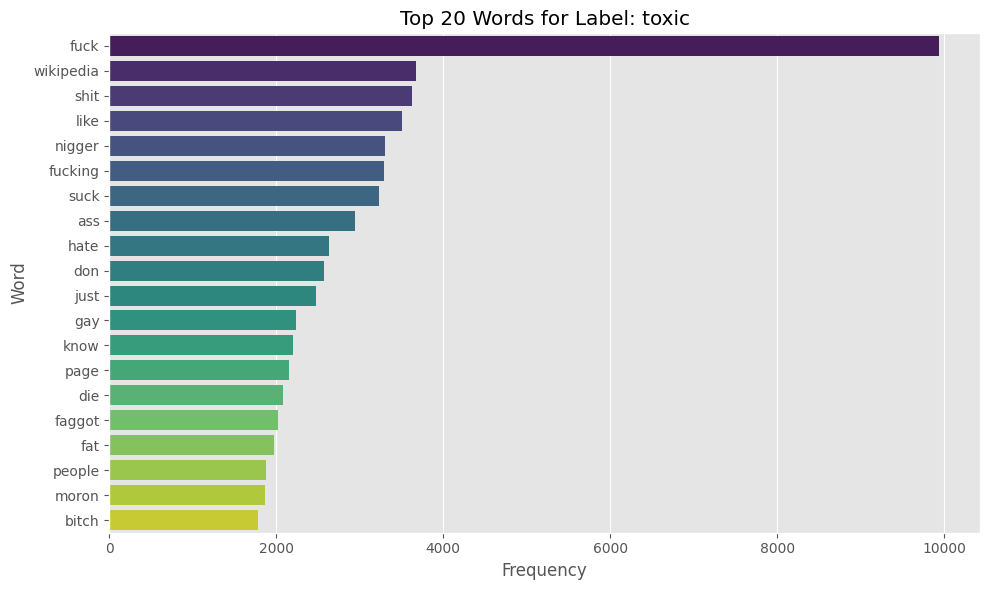

Top words for label: severe_toxic


<ipython-input-12-2a5cf608120c>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words, x="count", y="word", palette="viridis")


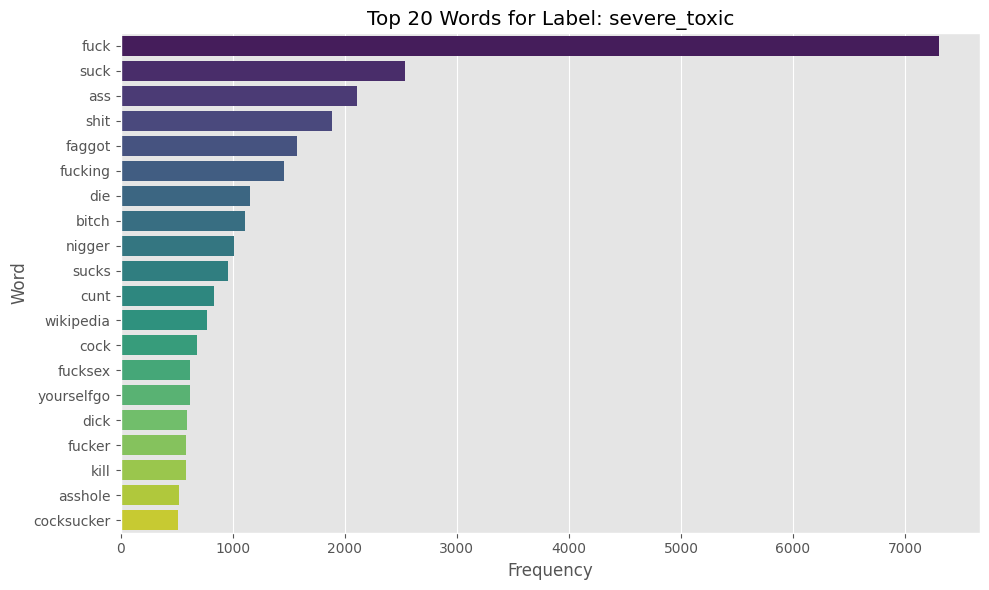

Top words for label: obscene


<ipython-input-12-2a5cf608120c>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words, x="count", y="word", palette="viridis")


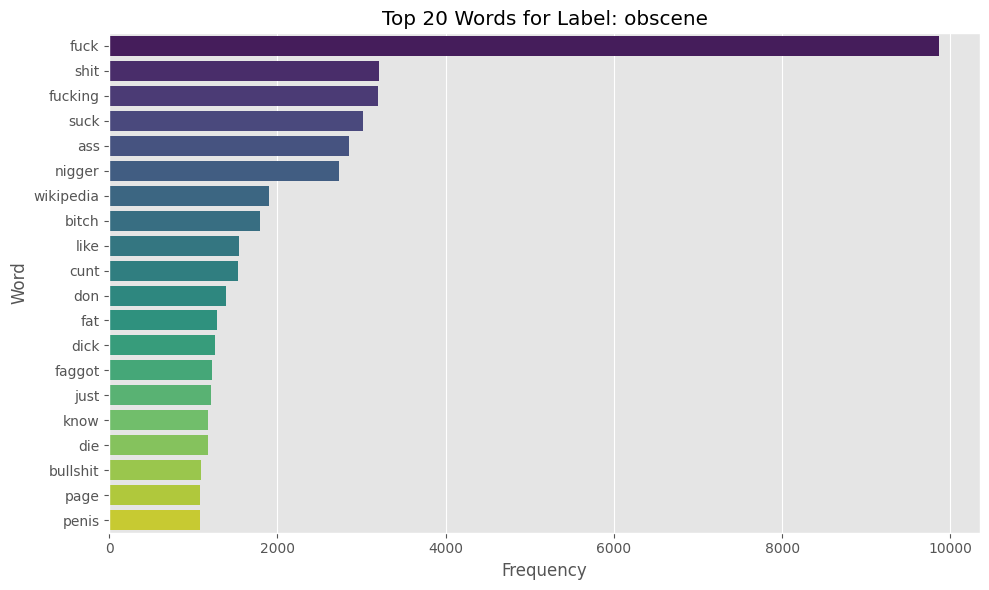

Top words for label: threat


<ipython-input-12-2a5cf608120c>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words, x="count", y="word", palette="viridis")


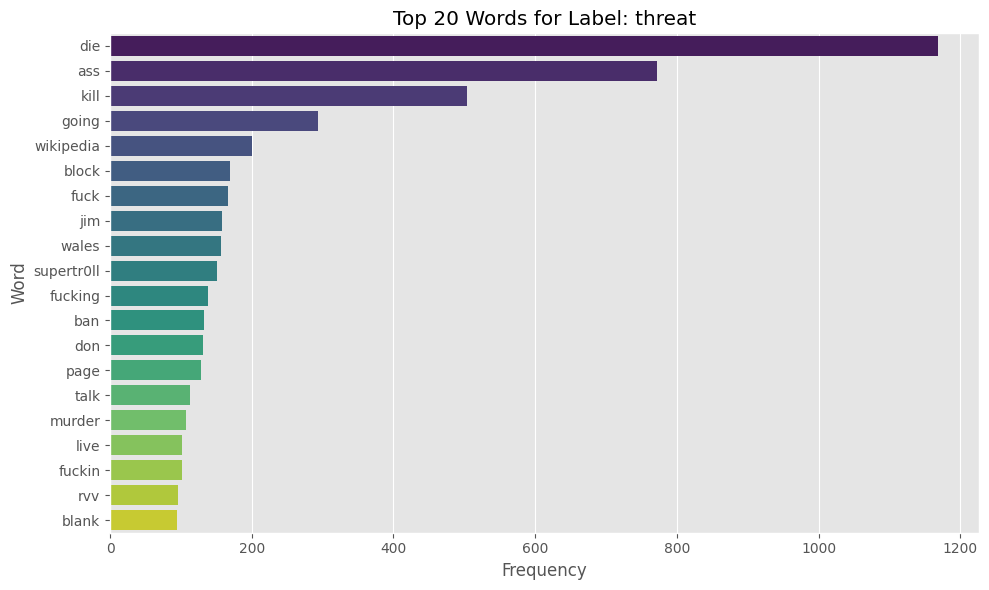

Top words for label: insult


<ipython-input-12-2a5cf608120c>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words, x="count", y="word", palette="viridis")


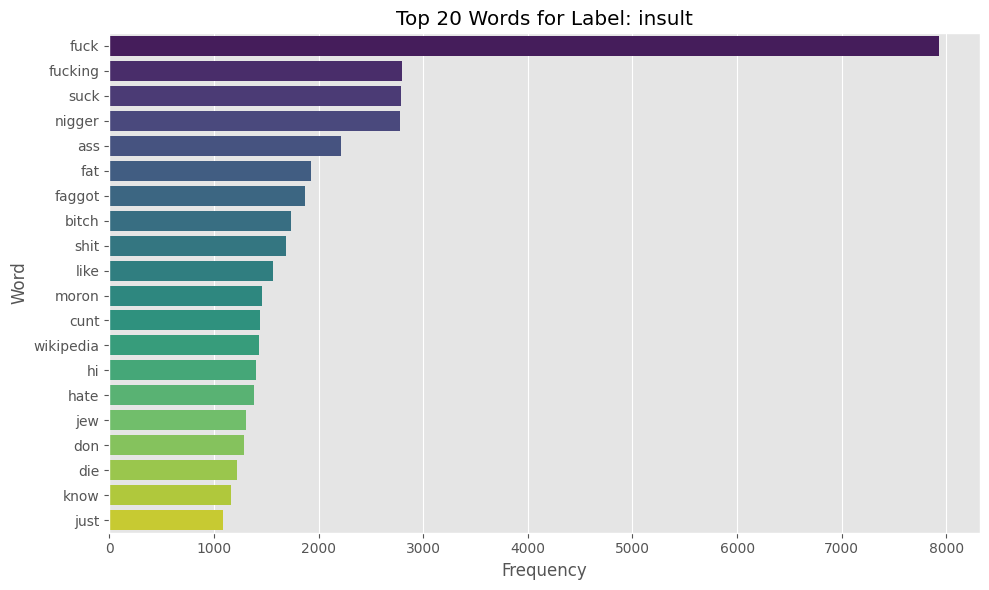

Top words for label: identity_hate


<ipython-input-12-2a5cf608120c>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words, x="count", y="word", palette="viridis")


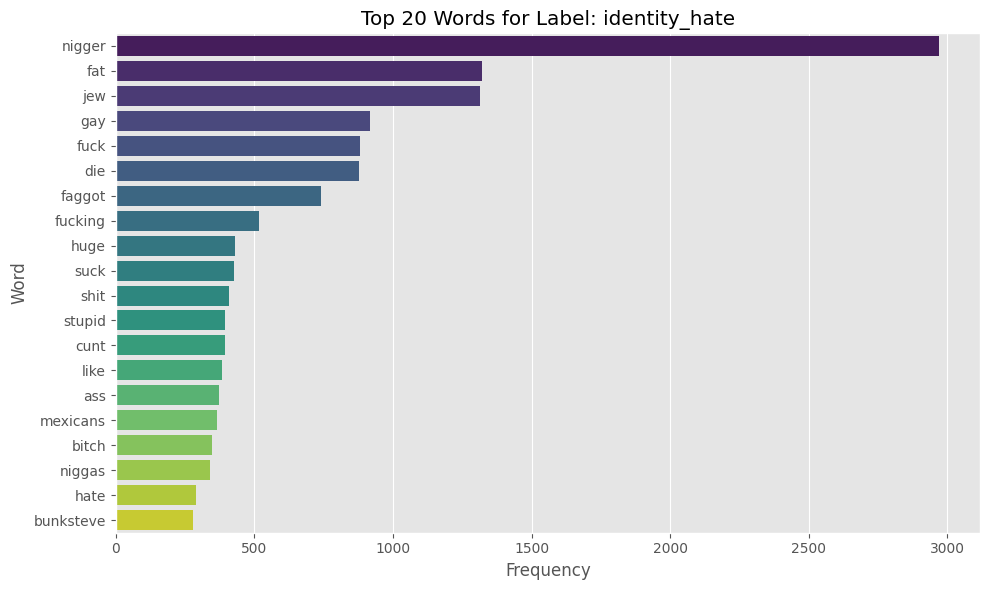

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter


# Loop through each label
for label in label_cols:
    print(f"Top words for label: {label}")

    # Filter comments where the label is 1
    filtered_text = training_data[training_data[label] == 1][text_column].dropna().astype(str)

    # Vectorize the text
    vec = CountVectorizer(stop_words='english', max_features=1000)
    X_counts = vec.fit_transform(filtered_text)
    word_counts = X_counts.sum(axis=0).A1
    words = vec.get_feature_names_out()

    # Create a DataFrame of word counts
    freq_df = pd.DataFrame({"word": words, "count": word_counts})
    top_words = freq_df.sort_values(by="count", ascending=False).head(20)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_words, x="count", y="word", palette="viridis")
    plt.title(f"Top 20 Words for Label: {label}")
    plt.xlabel("Frequency")
    plt.ylabel("Word")
    plt.tight_layout()
    plt.show()

In [ ]:
import nltk
nltk.download('stopwords')

punc = string.punctuation
punc.replace('#', '')
punc.replace('!', '')
punc.replace('?', '')
punc = punc + "∞θ÷α•à−β∅³π‘₹´°£€\×™√²—"

chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}


stpwds = stopwords.words('english')


time_zone_abbreviations = [
        "UTC", "GMT", "EST", "CST", "PST", "MST",
        "EDT", "CDT", "PDT", "MDT", "CET", "EET",
        "WET", "AEST", "ACST", "AWST", "HST",
        "AKST", "IST", "JST", "KST", "NZST"
    ]

patterns = [
    r'\\[nrtbfv\\]',         # \n, \t ..etc
    '<.*?>',                 # Html tags
    r'https?://\S+|www\.\S+',# Links
    r'\ufeff',               # BOM characters
    r'^[^a-zA-Z0-9]+$',      # Non-alphanumeric tokens
    r'ｗｗｗ．\S+',            # Full-width URLs
    r'[\uf700-\uf7ff]',      # Unicode private-use chars
    r'^[－—…]+$',            # Special punctuation-only tokens
    r'[︵︶]'                # CJK parentheses
]



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:

def remove_emojis(text):
    emoji_pattern = re.compile(
        "["                         # Start of group
        "\U0001F600-\U0001F64F"     # Emoticons
        "\U0001F300-\U0001F5FF"     # Symbols & pictographs
        "\U0001F680-\U0001F6FF"     # Transport & map symbols
        "\U0001F1E0-\U0001F1FF"     # Flags
        "\U00002700-\U000027BF"     # Dingbats
        "\U000024C2-\U0001F251"     # Enclosed characters
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

In [ ]:
def preprocess(text):
    for regex in patterns:
        text = re.sub(regex, '', text)
    text = text.translate(str.maketrans(punc, ' ' * len(punc)))
    text = ' '.join(word for word in text.split() if word not in time_zone_abbreviations)
    text = ' '.join(word for word in text.split() if word not in stpwds)
    text = ' '.join(chat_words.get(word.lower(), word) for word in text.split())
    text = text.lower()
    text = remove_emojis(text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
import nltk
nltk.download('punkt_tab')

comments = list(training_data["comment_text"])

# --- Tokenize and Build Vocabulary ---
token_lists = []
for comment in comments:
    cleaned = preprocess(comment)
    tokens = word_tokenize(cleaned)
    filtered = [t for t in tokens if 1 < len(t) < 25]
    token_lists.append(filtered)

# Flatten all tokens and build counter
all_tokens = [token for sublist in token_lists for token in sublist]
token_freq = Counter(all_tokens)

# --- Limit to top 30,000 words + <pad>, <unk> ---
vocab_size = 30000
special_tokens = ["<pad>", "<unk>"]
most_common_tokens = [token for token, _ in token_freq.most_common(vocab_size)]
final_vocab = special_tokens + most_common_tokens

# --- Create word-to-index mapping ---
word_to_index = {word: idx for idx, word in enumerate(final_vocab)}
PAD_IDX = word_to_index["<pad>"]
UNK_IDX = word_to_index["<unk>"]

# --- Display ---
print(f"Final vocabulary size: {len(final_vocab)}")
print("Sample valid tokens:", final_vocab[2:12])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Final vocabulary size: 30002
Sample valid tokens: ['article', 'the', 'page', 'wikipedia', 'talk', 'you', 'please', 'would', 'one', 'like']


In [ ]:
torch.save(final_vocab, "vocab.pth")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print out the device information
if device.type == 'cuda':
    print(f"Using GPU: {torch.cuda.get_device_name(device)}")
else:
    print("Using CPU")

Using GPU: Tesla T4


In [ ]:
def text_pipeline(text):
    return [
        final_vocab[token] if token in final_vocab else final_vocab['<unk>']
        for token in word_tokenize(text)  # Using NLTK's word_tokenize
    ]

def label_pipeline(labels):
    return torch.FloatTensor(labels)

In [ ]:

class PaddedDataset(Dataset):
    def __init__(self, df, vocab, word_to_index, max_length=None):
        self.df = df
        self.vocab = vocab
        self.word_to_index = word_to_index
        self.max_length = max_length
        self.label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx): # This function should be inside the class
        text = self.df.iloc[idx]['comment_text']
        labels = self.df.iloc[idx][self.label_cols].values.astype(float)

        # Tokenize with NLTK and numericalize
        tokens = word_tokenize(preprocess(text))
        if self.max_length:
            tokens = tokens[:self.max_length]
        numericalized = [self.word_to_index.get(token, UNK_IDX) for token in tokens]

        return torch.tensor(numericalized, dtype=torch.long), torch.tensor(labels, dtype=torch.float)



def collate_batch(batch):
    texts, labels = zip(*batch)
    lengths = torch.tensor([len(t) for t in texts])
     # Filter invalid sequences (length <=0)
    valid_mask = lengths > 0
    if not valid_mask.all():
        texts = [t for t, valid in zip(texts, valid_mask) if valid]
        labels = [l for l, valid in zip(labels, valid_mask) if valid]
        lengths = lengths[valid_mask]

    # Add fallback for empty batch
    if len(texts) == 0:
        return torch.zeros((1,1), dtype=torch.long), torch.zeros((1,6)), torch.tensor([1])
    # Pad sequences to match longest in batch
    padded_texts = torch.nn.utils.rnn.pad_sequence(
        texts,
        batch_first=True,
        padding_value=PAD_IDX
    )

    return padded_texts, torch.stack(labels), lengths

In [ ]:
BATCH_SIZE = 64
MAX_SEQ_LEN = 256

dataset = PaddedDataset(training_data, final_vocab, word_to_index,max_length=MAX_SEQ_LEN)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_batch,
    pin_memory=True,  # Faster data transfer to GPU
    num_workers=2     # Parallel data loading
)

Bidirectional LSTM

In [ ]:
class BIDirectional_lstm(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pad_idx, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx = pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout =  nn.Dropout(p = 0.3)
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted = False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden_output = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        out = self.fc1(hidden_output)
        out = self.dropout(out)
        return torch.sigmoid(out)

In [ ]:
def train_model(model, train_loader, val_loader, epochs, learning_rate, filename):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.BCELoss()
    best_val_loss = float('inf')
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for texts, labels, lengths in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
            # Move data to device
            texts, labels = texts.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(texts, lengths)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()

            # Calculate metrics
            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).all(dim=1).sum().item()
            total += labels.size(0)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for texts, labels, lengths in val_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts, lengths)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_correct += (predicted == labels).all(dim=1).sum().item()
                val_total += labels.size(0)

        # Epoch Statistics
        train_loss /= len(train_loader)
        train_acc = correct / total
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.2%}")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.2%}")

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), filename + '.pth')

    print("Training complete!")

In [ ]:
train_df, val_df = train_test_split(training_data.iloc[:, 1:], test_size=0.2)

train_dataset = PaddedDataset(train_df, final_vocab, word_to_index, max_length=256)
val_dataset = PaddedDataset(val_df, final_vocab, word_to_index, max_length=256)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=collate_batch,
    pin_memory=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    collate_fn=collate_batch,
    pin_memory=True,
    num_workers=2
)

In [ ]:
BIDirectional_model = BIDirectional_lstm(
    vocab_size=len(final_vocab),
    embed_dim=50,
    hidden_dim=256,
    output_dim=6,
    pad_idx=PAD_IDX
)

train_model(BIDirectional_model, train_loader, val_loader, 7, 0.0005, "bidirctional_lstm")

Epoch 1: 100%|██████████| 1995/1995 [02:28<00:00, 13.43it/s]



Epoch 1/7
Train Loss: 0.2780 | Acc: 89.75%
Val Loss: 0.0782 | Acc: 91.01%


Epoch 2: 100%|██████████| 1995/1995 [02:23<00:00, 13.94it/s]



Epoch 2/7
Train Loss: 0.2513 | Acc: 90.48%
Val Loss: 0.0674 | Acc: 91.31%


Epoch 3: 100%|██████████| 1995/1995 [02:22<00:00, 13.97it/s]



Epoch 3/7
Train Loss: 0.2447 | Acc: 90.73%
Val Loss: 0.0622 | Acc: 91.44%


Epoch 4: 100%|██████████| 1995/1995 [02:22<00:00, 13.98it/s]



Epoch 4/7
Train Loss: 0.2412 | Acc: 90.96%
Val Loss: 0.0542 | Acc: 91.64%


Epoch 5: 100%|██████████| 1995/1995 [02:21<00:00, 14.12it/s]



Epoch 5/7
Train Loss: 0.2382 | Acc: 91.15%
Val Loss: 0.0543 | Acc: 91.70%


Epoch 6: 100%|██████████| 1995/1995 [02:20<00:00, 14.15it/s]



Epoch 6/7
Train Loss: 0.2353 | Acc: 91.36%
Val Loss: 0.0525 | Acc: 91.71%


Epoch 7: 100%|██████████| 1995/1995 [02:21<00:00, 14.08it/s]



Epoch 7/7
Train Loss: 0.2322 | Acc: 91.67%
Val Loss: 0.0496 | Acc: 91.69%
Training complete!
